# Importations

In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3
import numpy as np

from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20
from scipy.optimize import curve_fit
mpl.rc('image', cmap='plasma') 
import gc
import time, sys
import os
from PIL import Image
import math
from skimage import io
import ipywidgets as widgets

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Extraction of data

In [2]:
gc.collect()

0

In [3]:
path = 'C:/Users/Brian/'

#Les infos sur les fichiers x et y sont compris dans le fichier parametres (Taille de la porte, vitesse des chlamys, etc...)
folder = path + 'Simulations/data_simulations/N10000D10V90_theil/'
data = path + 'Simulations/data_resultats/N10000D10V90_theil/'

#Create the folder where your data will be saved
if not os.path.exists(data):
    os.mkdir(data)

In [4]:
#On extrait auelaues parametres pertinents de la simulation analysee ici.

parametres = genfromtxt(folder + 'parametres.txt', skip_header = 1)
total_frame = int(parametres[0])
frame_par_fichier = int(parametres[1])
framerate = parametres[2]
Taille_x = parametres[3]
Taille_y = parametres[4]
taille_porte = parametres[5]
angle_porte = parametres[6]
vitesse = parametres[7]
N = int(parametres[8])
alpha = parametres[9]
Dr = parametres[10]
k = parametres[11]

In [5]:
#On extrait les coordonnees des particules

x = genfromtxt(folder + "fichier_x_" + str(total_frame//frame_par_fichier-1) + ".txt", skip_header = 1)
y = genfromtxt(folder + "fichier_y_" + str(total_frame//frame_par_fichier-1) + ".txt", skip_header = 1)

#x = genfromtxt(folder + "fichier_x_3.txt", skip_header = 1)
#y = genfromtxt(folder + "fichier_y_3.txt", skip_header = 1)

# Visualizing the video

In [6]:
#Drawing of the interactive figure

def graphe(frame):
       
    fig = plt.figure(figsize=(16, 3))
    plt.scatter(x[frame, 1:], y[frame, 1:], alpha = 0.8, s = 1, c = 'k')
    #plt.title(f'Position des particules dans la frame {frame}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, Taille_x/2)
    plt.ylim(0, Taille_y)
    plt.show()
    
    #Saving slider values into variables
    global slider_frame
    slider_frame = frame    
    #end of the function

    
#definig the slider to visualize the frames


#Executing the sliders
widgets.interact(graphe,
                 frame=widgets.IntSlider(
                     value=0,
                     min=0,
                     max=np.shape(x)[0]-1,
                     step=1,description='frame',
                     disabled=False,
                     continuous_update=False,
                     readout=True,
                     readout_format='.1f',))

interactive(children=(IntSlider(value=0, continuous_update=False, description='frame', max=499, readout_format…

<function __main__.graphe(frame)>

In [12]:
x_particule1 = np.zeros(total_frame)
y_particule1 = np.zeros(total_frame)

x_particule2 = np.zeros(total_frame)
y_particule2 = np.zeros(total_frame)

x_particule3 = np.zeros(total_frame)
y_particule3 = np.zeros(total_frame)

for fichier in range(total_frame//frame_par_fichier):
    
    xfirst = genfromtxt(folder + "fichier_x_" + str(fichier) + ".txt", skip_header = 1)
    yfirst = genfromtxt(folder + "fichier_y_" + str(fichier) + ".txt", skip_header = 1)
    
    x_particule1[fichier*frame_par_fichier:fichier*frame_par_fichier+frame_par_fichier] = xfirst[:, 1002]
    y_particule1[fichier*frame_par_fichier:fichier*frame_par_fichier+frame_par_fichier] = yfirst[:, 1002]
    
    x_particule2[fichier*frame_par_fichier:fichier*frame_par_fichier+frame_par_fichier] = xfirst[:, 1003]
    y_particule2[fichier*frame_par_fichier:fichier*frame_par_fichier+frame_par_fichier] = yfirst[:, 1003]

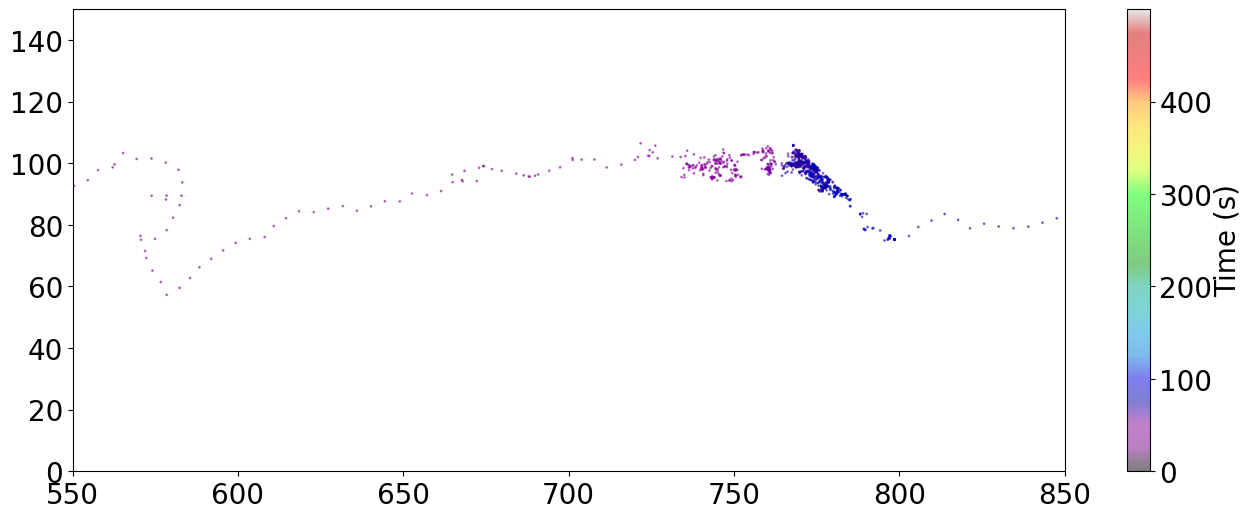

In [15]:
plt.figure(figsize=(16,6))

plt.scatter(x_particule1, y_particule1, c = np.arange(total_frame)/framerate, cmap = 'nipy_spectral', s = 1, alpha = 0.5)

plt.xlim(550,850)
plt.ylim(0, 150)

cbar= plt.colorbar()
cbar.set_label("Time (s)", labelpad=+1)

plt.show()

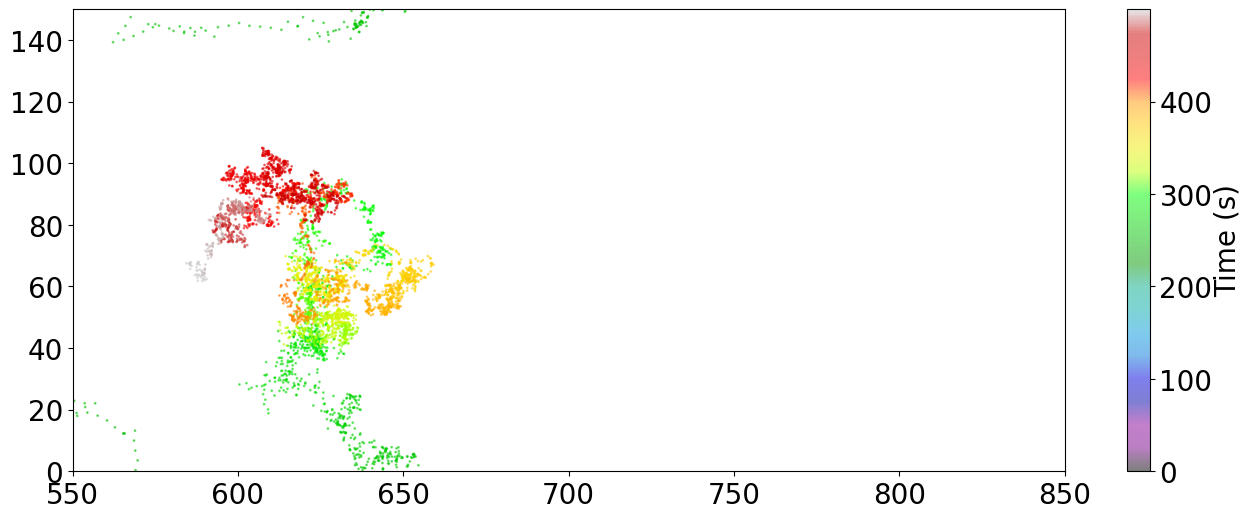

In [16]:
plt.figure(figsize=(16,6))

plt.scatter(x_particule2, y_particule2, c = np.arange(total_frame)/framerate, cmap = 'nipy_spectral', s = 1, alpha = 0.5)

plt.xlim(550,850)
plt.ylim(0, 150)

cbar= plt.colorbar()
cbar.set_label("Time (s)", labelpad=+1)

plt.show()

# Profil de densite

In [9]:
#Nous calculons la densite de particules avec l'abscisse x avamt la porte pour retrouver l'arcangeante
#du profil d'intensite (code upstream)
X = np.linspace(0, int(Taille_x/2), int(Taille_x/2 + 1))
dY = np.zeros(np.shape(X)[0])

#On prend en compte l'evolution de la largeur Y accessible aux algues pour le calcul de densite
for k in range(int(Taille_x/2 - (Taille_y - taille_porte)/(2*np.tan(angle_porte)))+1):
    dY[k] = Taille_y
for k in range(int(Taille_x/2 - (Taille_y - taille_porte)/(2*np.tan(angle_porte)))+1, int(Taille_x/2 + 1)):
    dY[k] = taille_porte + 2*(Taille_x/2 - k)*np.tan(angle_porte)

In [10]:
#On calcule le profil de densite d'abord frame par frame dans le fichier lu
densite_along_x = np.zeros((total_frame, np.shape(X)[0]))

for fichier in range(total_frame//frame_par_fichier):
    
    xfirst = genfromtxt(folder + "fichier_x_" + str(fichier) + ".txt", skip_header = 1)
    yfirst = genfromtxt(folder + "fichier_y_" + str(fichier) + ".txt", skip_header = 1)

    densite_along_x_fichier = np.zeros((frame_par_fichier, np.shape(X)[0]))

    for frame in range(frame_par_fichier):
        for k in range(np.shape(X)[0]):
            densite_along_x_fichier[frame][k] = np.shape(xfirst[frame][1:][((xfirst[frame][1:] >= k) & (xfirst[frame][1:] < k+1))])[0]
            densite_along_x_fichier[frame][k] = densite_along_x_fichier[frame][k]/dY[k]
            densite_along_x[fichier*frame_par_fichier+frame] = densite_along_x_fichier[frame] 

In [11]:
#On trace le profil de densite dans un graphe interactif

def graphe(frame):
       
    fig = plt.figure(figsize=(16, 3))
    plt.plot(X, densite_along_x[frame])
    plt.title(f'Profil de densite dans la frame {frame}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(0, Taille_x/2)
    plt.show()
    
    #Saving slider values into variables
    global slider_frame
    slider_frame = frame    
    #end of the function

    
#definig the slider to visualize the frames


#Executing the sliders
widgets.interact(graphe,
                 frame=widgets.IntSlider(
                     value=0,
                     min=0,
                     max=total_frame-1,
                     step=1,description='frame',
                     disabled=False,
                     continuous_update=False,
                     readout=True,
                     readout_format='.1f',))

interactive(children=(IntSlider(value=0, continuous_update=False, description='frame', max=9999, readout_forma…

<function __main__.graphe(frame)>

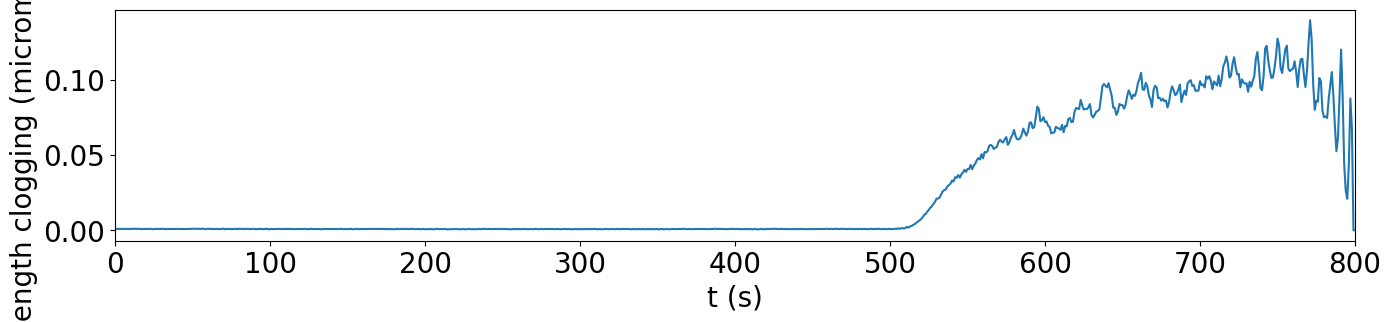

In [12]:
mean_densite = np.mean(densite_along_x[-500:], axis = 0)

fig = plt.figure(figsize=(16, 3))
plt.plot(X, mean_densite) 
plt.xlabel('t (s)')
plt.ylabel('length clogging (micrometer)')
plt.xlim(0, 800)

np.savetxt(data + "mean_density.txt", np.array([X, mean_densite]), header = 't L')
plt.savefig(data + 'mean_density')

plt.show()

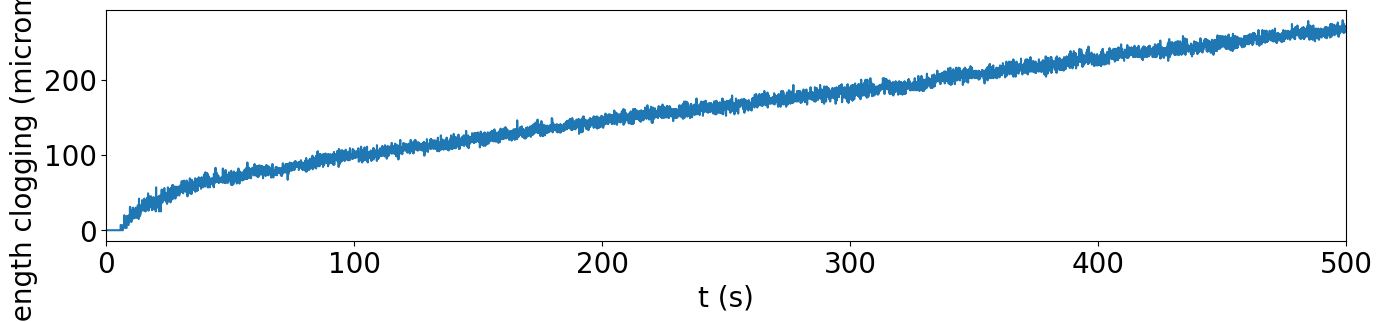

In [13]:
length_clogging = np.zeros(total_frame)

for frame in range(total_frame):
    if np.shape(densite_along_x[frame][densite_along_x[frame]>0.04])[0] > 0:
        x0 = np.min(X[densite_along_x[frame]>0.04])
    else:
        x0 = 800
    length_clogging[frame] = 800-x0
    
T = np.arange(total_frame)/framerate
fig = plt.figure(figsize=(16, 3))
plt.plot(T, length_clogging) 
plt.xlabel('t (s)')
plt.ylabel('length clogging (micrometer)')
plt.xlim(0, 500)

np.savetxt(data + "length_clogging.txt", np.array([T, length_clogging]), header = 't L')
plt.savefig(data + 'length_clogging')

plt.show()

# Calculation of I(r) ~ g(r)

In [22]:
gc.collect()

1509

In [23]:
#On initialise le tableau [pur stocker les distances entre deux particules
distances = np.zeros(N)
r = np.arange(500, dtype = int)
g = np.zeros(np.shape(r)[0])

for i in range(N):
    for frame in range(frame_par_fichier):
    
        if ((x[frame,i] > 600) & (x[frame,i] < 750)):
            distances = np.where((x[frame,1:] > 600) & (x[frame,1:] < 750), sqrt((x[frame,i+1]-x[frame,1:])**2 + (y[frame,i+1]-y[frame,1:])**2), 0)
        
        r_frame, g_frame = np.unique(np.array(distances, dtype=int), return_counts = True)
        g[:np.shape(g_frame)[0]][r[:np.shape(r_frame)[0]] == r_frame] += g_frame[r[:np.shape(r_frame)[0]] == r_frame]

g[0] = 0
g = g/(2*np.sum(g))
g[1:] = g[1:]/r[1:]

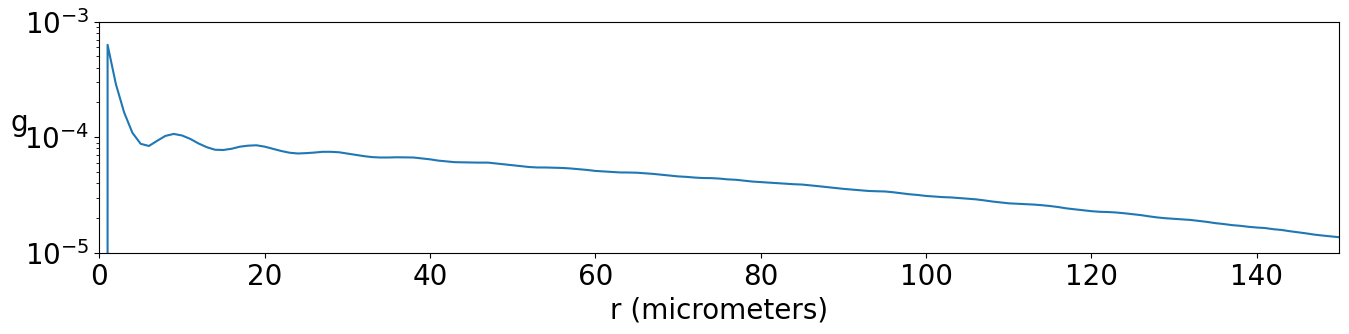

In [26]:
#On trace la RDF

plt.figure(figsize=(16,3))

plt.plot(r, g)

plt.xlabel('r (micrometers)')
plt.ylabel('g', rotation = 0)
plt.xlim(0,150)
plt.ylim(1e-5, 1e-3)
#plt.ylim(1e-6, 2*np.max(P))
plt.yscale('log')

np.savetxt(data + "RDF.txt", np.array([r, g]), header = 'r g(r)')
plt.savefig(data + 'RDF')

plt.show()

# Fonction de survie

In [17]:
gc.collect()

2806

In [18]:
#On calcule ici la distribution de probabilite rho(t) (These Edouardo) en fonction de l'evolution du nobre de particules
#situees a droite de la porte 

Delta_t = np.arange(0, x[-1,0] - x[0,0], x[1,0] - x[0,0], dtype = float)
rho = np.zeros(np.shape(Delta_t)[0])

dt = 0

for fichier in range(total_frame//frame_par_fichier):
    
    xfirst = genfromtxt(folder + "fichier_x_" + str(fichier) + ".txt", skip_header = 1)
    yfirst = genfromtxt(folder + "fichier_y_" + str(fichier) + ".txt", skip_header = 1)



    
    for t in range(frame_par_fichier-1):
        N_droite_t = np.shape(xfirst[t][xfirst[t]>800])[0]  # nbr de particules a droite a l'instant t
        N_droite_t_dt = np.shape(xfirst[t+1][xfirst[t+1]>800])[0]  # nbr de particules a droite a l'instant t+dt
        N_back_t = np.shape(np.diff(xfirst[t:t+1], axis = 0)[np.diff(xfirst[t:t+1], axis = 0)<-1000])[0]  #nbr de particules
                                                                                                      #franchissant la condition
                                                                                                      #à la limite en xfirst
    
        N_passage_t = N_droite_t_dt - N_droite_t + N_back_t
    
        #Ici, en fonctin du nombre de passage par la porte mesure, on remplit le tableau de distribution de probabilite
        if N_passage_t == 0:
            dt += 1
        
        elif N_passage_t == 1:
            rho[dt] += 1
            dt = 0
    
        else:
            rho[dt] += 1
            rho[0] += N_passage_t-1
            dt = 0
   
        
rho = rho / np.sum(rho)

In [19]:
#On calcule ici la fonction de survie grace a la distribution de probabilite

P = np.zeros(np.shape(Delta_t)[0])

for t in range(np.shape(P)[0]):
    P[t] = np.sum(rho[t:])
P = P/P[1]    

np.savetxt(data + "rho.txt", np.array([Delta_t, rho]), header = 'Delta_t rho(t)')
np.savetxt(data + "survival_function.txt", np.array([Delta_t, P]), header = 'Delta_t P(Delta_t<t)')

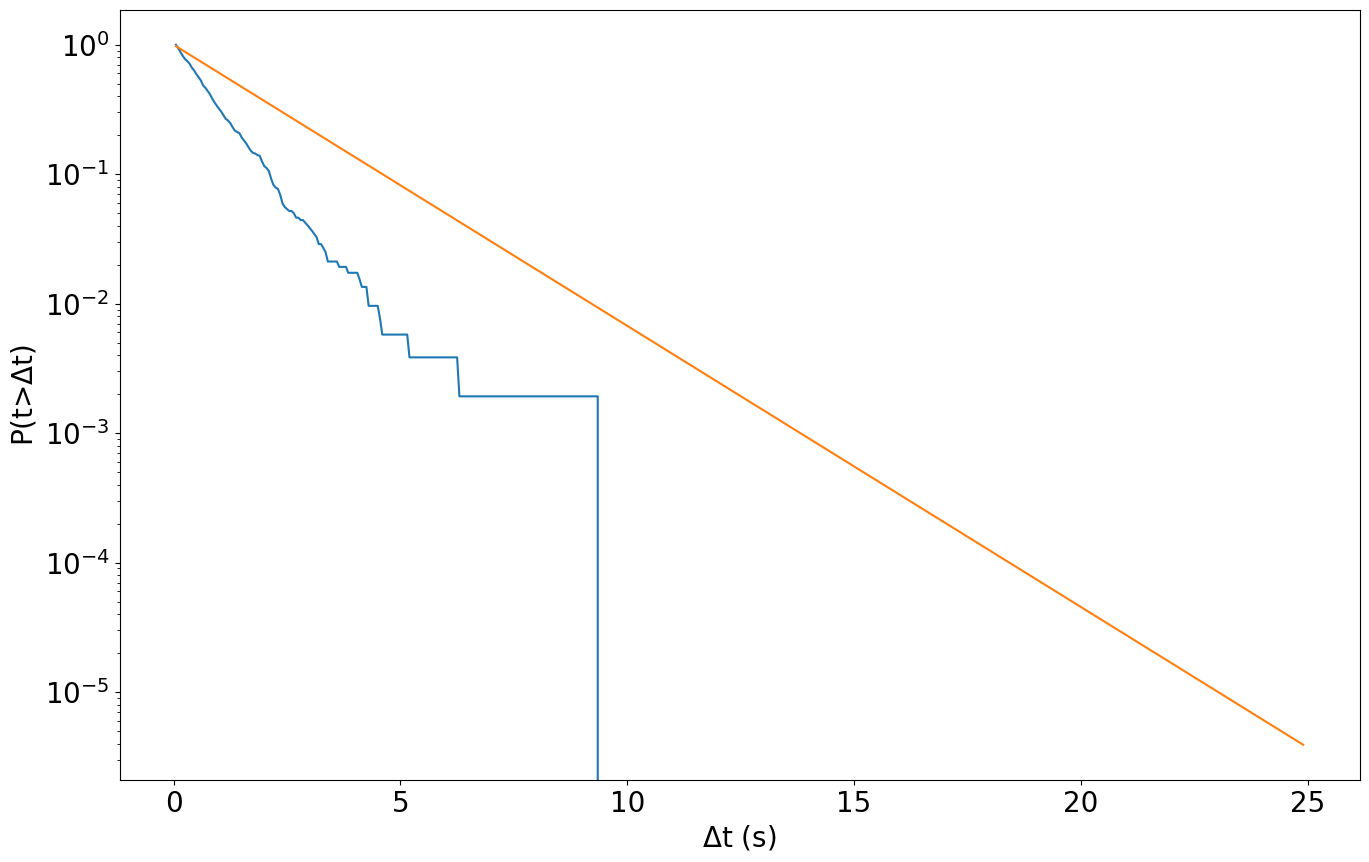

In [20]:
plt.figure(figsize=(16,10))

plt.plot(Delta_t[1:], P[1:])
plt.plot(Delta_t[1:], np.exp(-Delta_t[1:]/(9*framerate/90)))
plt.xlabel(r'$\Delta$t (s)')
plt.ylabel(r'P(t>$\Delta$t)')
plt.xscale('linear')
plt.yscale('log')
#plt.xlim(0.05, 10)
#plt.ylim(0.01, 50)

plt.savefig(data + 'Survival_Function_log_lin')


plt.show()

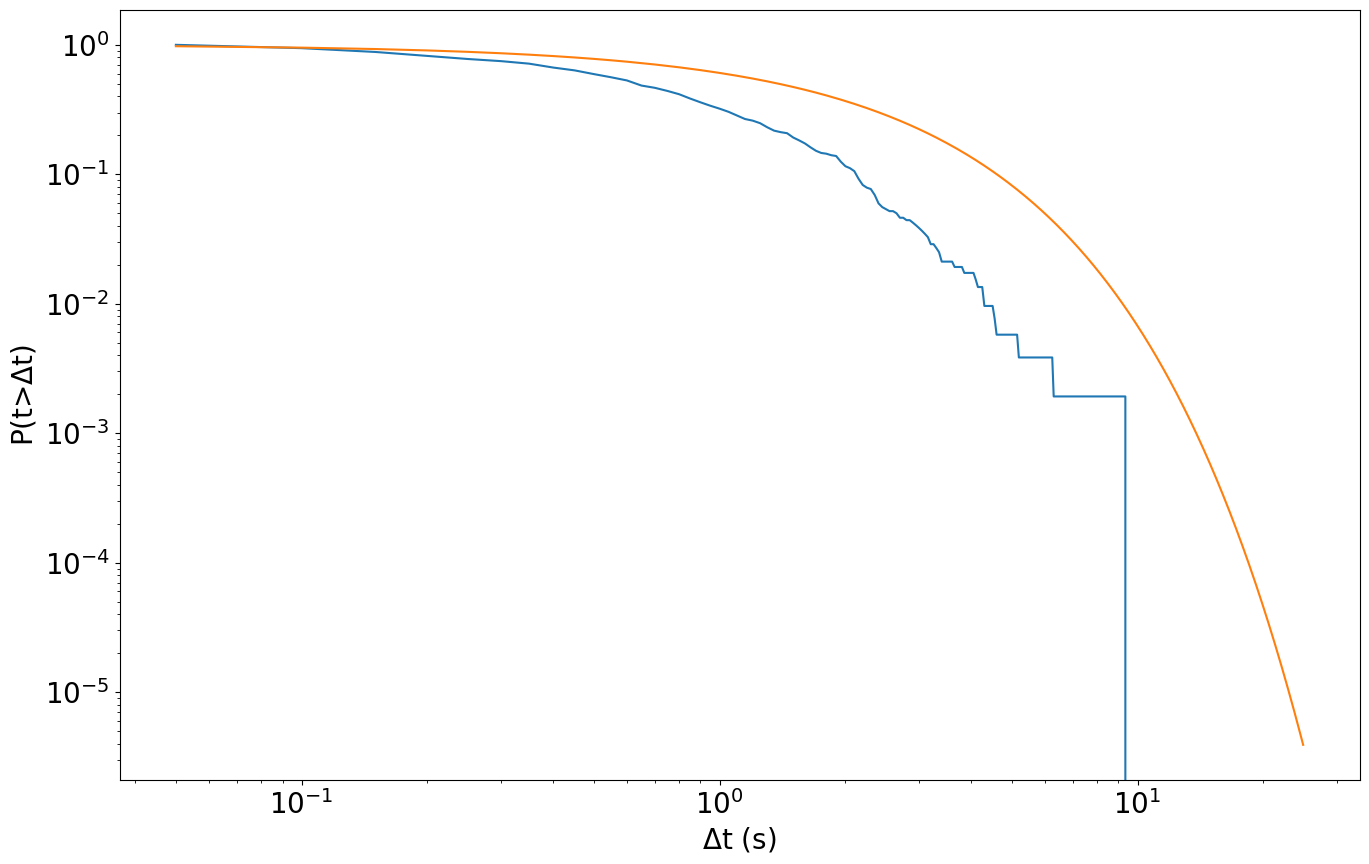

In [21]:
plt.figure(figsize=(16,10))

plt.plot(Delta_t[1:], P[1:])
plt.plot(Delta_t[1:], np.exp(-Delta_t[1:]/(9*framerate/90)))
plt.xlabel(r'$\Delta$t (s)')
plt.ylabel(r'P(t>$\Delta$t)')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(0.05, 10)
#plt.ylim(0.01, 50)

plt.savefig(data + 'Survival_Function_log_log')

plt.show()

# MSD 

In [22]:
gc.collect()

58960

### Version longue avec porte

### Version courte avec porte

In [6]:
#On calcule le MSD des particules dans la simulation> Mesure qu'on ne peut pas avoir experimentalement si il y a clogging

#On initialise les tableaux necessaires par la suite
MSD = np.zeros((N,frame_par_fichier-1))
MSD_along_x = np.zeros((N,frame_par_fichier-1))
MSD_along_y = np.zeros((N,frame_par_fichier-1))
diff_t = np.zeros(frame_par_fichier-1)

k = 0
#on boucle sur les particules
for i in range(N):
    
    #Pour les simulations ou ça nous interesse, on ne grde aussi que les particules du clogging
    if ((x[0,i+1] > 600) & (x[frame_par_fichier-1,i+1] < 800)):
        
        
        #On boucle sur les frames du fichier lu
        for j in range(frame_par_fichier-1):
        
            #Les conditions where permettent de ne pas prendre en compte les cas ou les particules ont franchi une condition
            #limite sur un bord. Ceci fausserait le MSD sur x ou y. On essaie cependant de garder le plus de data possible meme
            #si la complexite est enorme.
        
            
        
            #Les lignes isnan permettent de ne conserver aue des valeurs numeriaques dans le tableau meme si on moyenne sur des
            #listes vides avec les conditions where   
            MSD[i][j] = np.mean((x[j+1:,i+1]-x[:-j-1,i+1])**2 + (y[j+1:,i+1]-y[:-j-1,i+1])**2, where = (((x[j+1:,i+1]-x[:-j-1,i+1])**2 + (y[j+1:,i+1]-y[:-j-1,i+1])**2) < 10*j).all())
            if np.isnan(MSD[i][j]):
                MSD[i][j] = MSD[i][j-1]
                    
            MSD_along_x[i][j] = np.mean((x[j+1:,i+1]-x[:-j-1,i+1])**2, where = (((x[j+1:,i+1]-x[:-j-1,i+1])**2) < 5*j).all())
            if np.isnan(MSD_along_x[i][j]):
                MSD_along_x[i][j] = MSD_along_x[i][j-1]
         
            MSD_along_y[i][j] = np.mean((y[j+1:,i+1]-y[:-j-1,i+1])**2, where = (((y[j+1:,i+1]-y[:-j-1,i+1])**2) < 5*j).all())
            if np.isnan(MSD_along_y[i][j]):
                MSD_along_y[i][j] = MSD_along_y[i][j-1]
    
                    
            diff_t[j] = (j+1)*(x[1][0]-x[0][0])

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Sans porte

In [ ]:
#On calcule le MSD des particules dans la simulation> Mesure qu'on ne peut pas avoir exxperimentalement si il y a clogging

#On initialise les tableaux necessaires par la suite
MSD = np.zeros((N,frame_par_fichier-1))
MSD_along_x = np.zeros((N,frame_par_fichier-1))
MSD_along_y = np.zeros((N,frame_par_fichier-1))
diff_t = np.zeros(frame_par_fichier-1)

#on boucle sur les particules
for i in range(N):

    
    #On boucle sur les frames du fichier lu
    for j in range(frame_par_fichier-1):
        
        #Les conditions where permettent de ne pas prendre en compte les cas ou les particules ont franchi une condition
        #limite sur un bord. Ceci fausserait le MSD sur x ou y. On essaie cependant de garder le plus de data possible meme
        #si la complexite est enorme.
        
        #Pour les simulations ou ça nous interesse, on ne grde aussi que les particules du clogging
        
        #Les lignes isnan permettent de ne conserver aue des valeurs numeriaques dans le tableau meme si on moyenne sur des
        #listes vides avec les conditions where  
        MSD[i][j] = np.mean((x[j+1:,i+1]-x[:-j-1,i+1])**2 + (y[j+1:,i+1]-y[:-j-1,i+1])**2)            
        MSD_along_x[i][j] = np.mean((x[j+1:,i+1]-x[:-j-1,i+1])**2)
        MSD_along_y[i][j] = np.mean((y[j+1:,i+1]-y[:-j-1,i+1])**2)
        diff_t[j] = (j+1)*(x[1][0]-x[0][0])

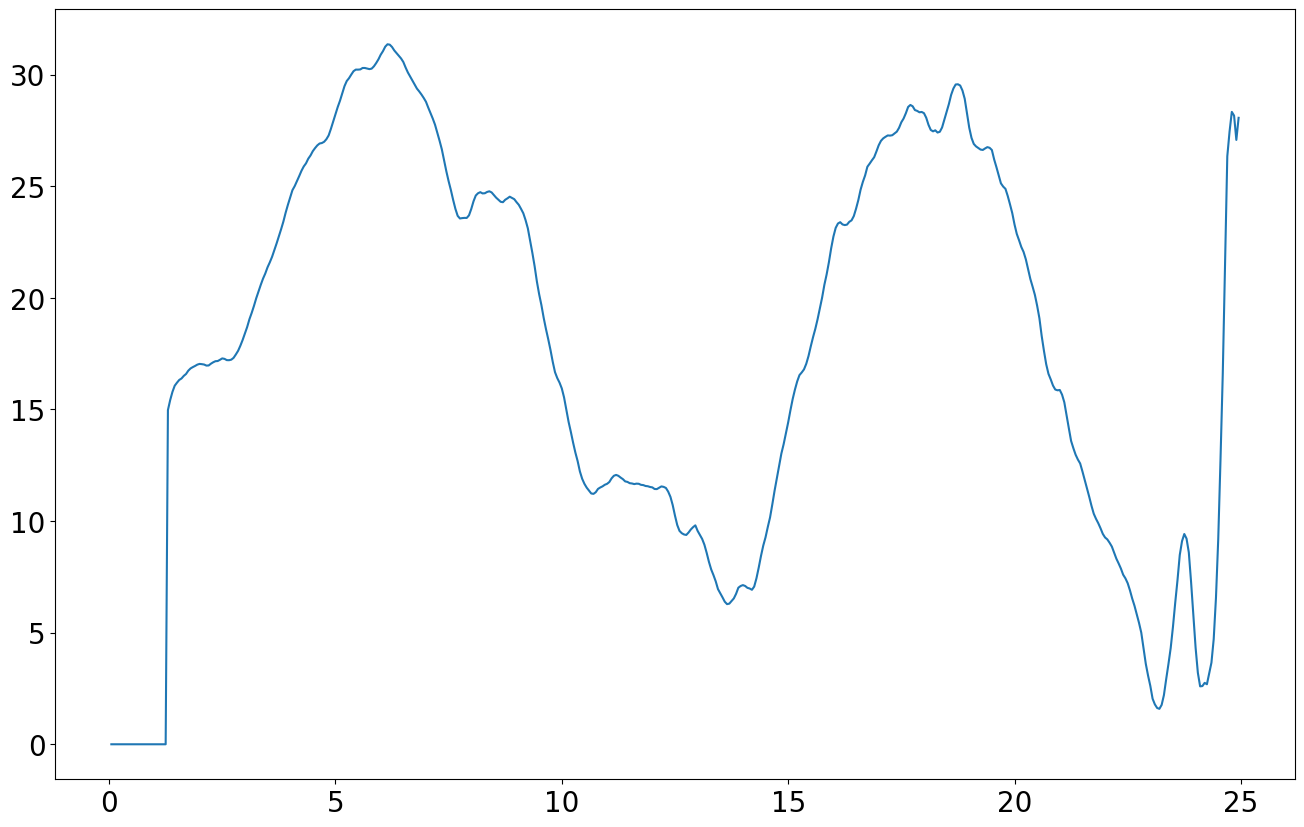

In [7]:
#On trace les MSD interessants

plt.figure(figsize=(16,10))

plt.plot(diff_t, MSD_along_y[1003])

plt.show()

In [8]:
mean_MSD = np.mean(MSD, axis = 0, where = np.sum(MSD, axis = 0) > 0)
mean_MSD_along_x = np.mean(MSD_along_x, axis = 0, where = np.sum(MSD_along_x, axis = 0) > 0)
mean_MSD_along_y = np.mean(MSD_along_y, axis = 0, where = np.sum(MSD_along_y, axis = 0) > 0)

np.savetxt(data + "MSD.txt", np.array([diff_t, mean_MSD]), header = 'dt  MSD')
np.savetxt(data + "MSD_along_x.txt", np.array([diff_t, mean_MSD_along_x]), header = 'dt  MSD_along_x')
np.savetxt(data + "MSD_along_y.txt", np.array([diff_t, mean_MSD_along_y]), header = 'dt  MSD_along_y')

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [9]:
print(np.max(MSD_along_y[:,0]))

0.0


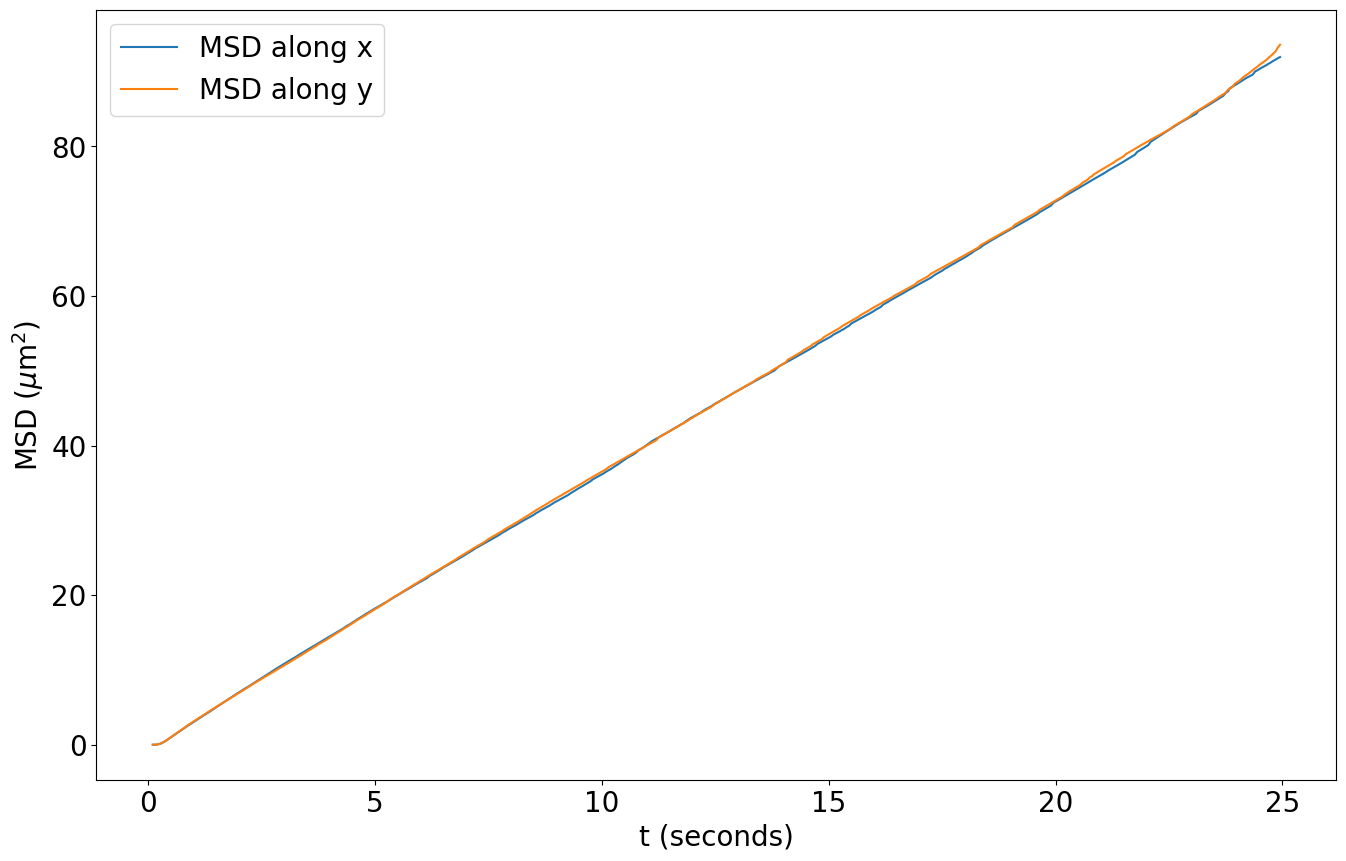

In [10]:
plt.figure(figsize=(16,10))
plt.plot(diff_t, mean_MSD_along_x, label = 'MSD along x')
plt.plot(diff_t, mean_MSD_along_y, label = 'MSD along y')
#plt.xlim(0,15)
#plt.ylim(0,200000)
plt.xlabel('t (seconds)')
plt.ylabel(r'MSD ($\mu$m$^2$)')
plt.yscale('linear')
plt.yscale('linear')

plt.legend()

plt.savefig(data + 'MSD_along_each_axis')

plt.show()

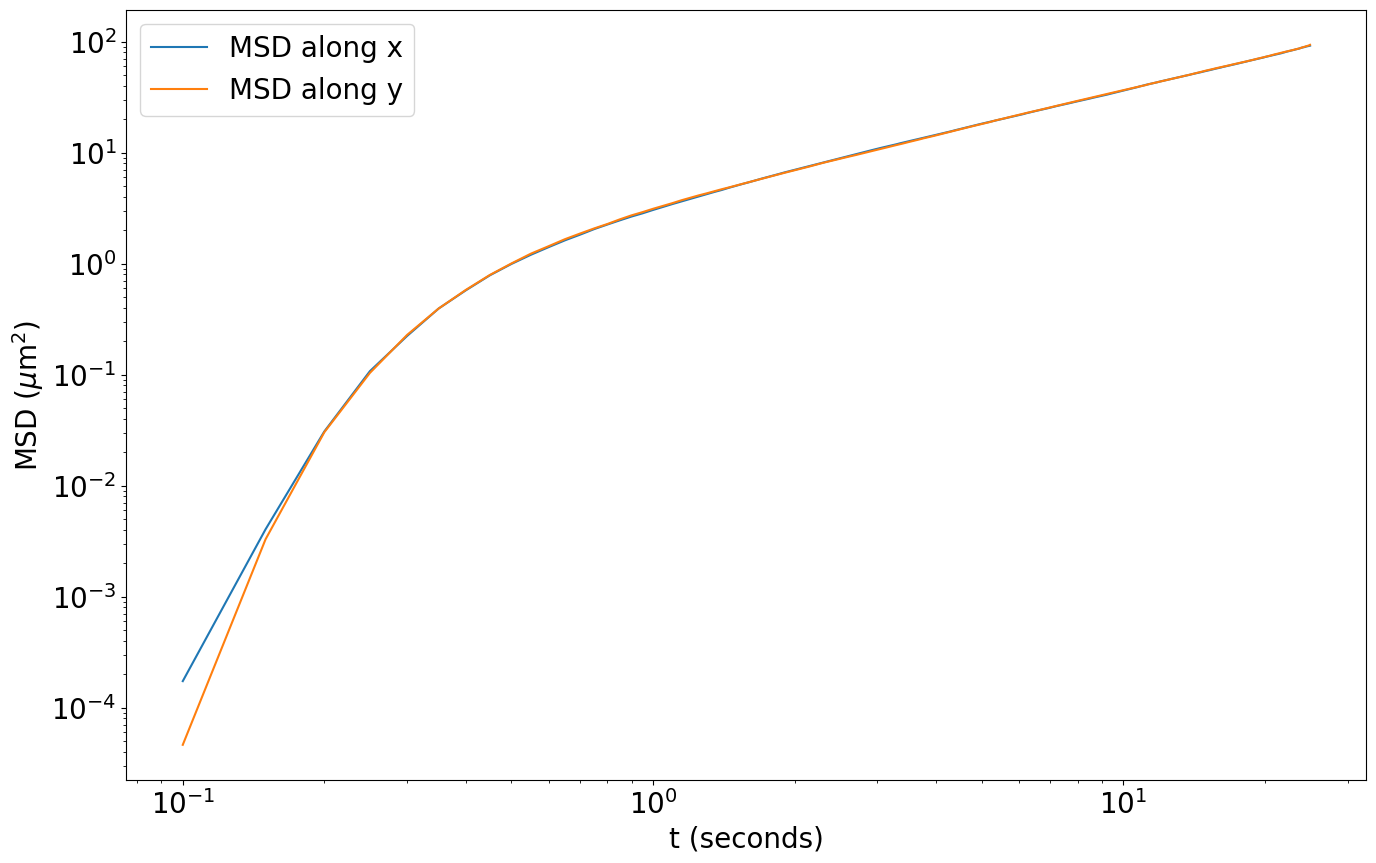

In [11]:
plt.figure(figsize=(16,10))
plt.plot(diff_t, mean_MSD_along_x, label = 'MSD along x')
plt.plot(diff_t, mean_MSD_along_y, label = 'MSD along y')
#plt.xlim(0,2)
#plt.ylim(0,10000)
plt.xlabel('t (seconds)')
plt.ylabel(r'MSD ($\mu$m$^2$)')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.savefig(data + 'MSD_along_each_axis_reduit')

plt.show()

In [12]:
def lineaire(t, a, b):
    return a*t + b

In [21]:
optballx, covballx = curve_fit(lineaire, (diff_t[1:][diff_t[1:]<=0.2])**2, mean_MSD_along_x[1:][diff_t[1:]<=0.2])
optbally, covbally = curve_fit(lineaire, (diff_t[1:][diff_t[1:]<=0.2])**2, mean_MSD_along_y[1:][diff_t[1:]<=0.2])
optdiffx, covdiffx = curve_fit(lineaire, diff_t[diff_t>=20], mean_MSD_along_x[diff_t>=20])
optdiffy, covdiffy = curve_fit(lineaire, diff_t[diff_t>=20], mean_MSD_along_y[diff_t>=20])

print(optballx)
print(optbally)
print(optdiffx/2)
print(optdiffy/2)

[ 0.30940457 -0.0029211 ]
[ 0.25915155 -0.00254537]
[ 1.98996269 -3.67876635]
[ 1.99904844 -3.68250351]


# Autocorrelation des vitesses

In [39]:
#Calcul des vitesses

dt = x[1][0]
dx = np.diff(x[:,1:], axis = 0)
dy = np.diff(y[:,1:], axis = 0)

vx = dx/dt
vy = dy/dt

### Distribution des angles

In [31]:
#On determine ici la distribution des angles des algues dans l'experience

Angle = np.arctan2(vy, vx)
angle = np.linspace(-3, 3, 200)
distribution = np.zeros(200)

#On boucle sur les angles theta allant de -2Pi a +2Pi en passant par 200 valeurs
for THETA in range (200):
    distribution[THETA] = np.shape(Angle[(Angle>=(THETA*3/100)-3) & (Angle<(THETA*3/100)-3+0.1)])[0]
    
np.savetxt(data + "distribution_angle_orientation.txt", np.array([angle, distribution]), header = '                 angle              distribution')


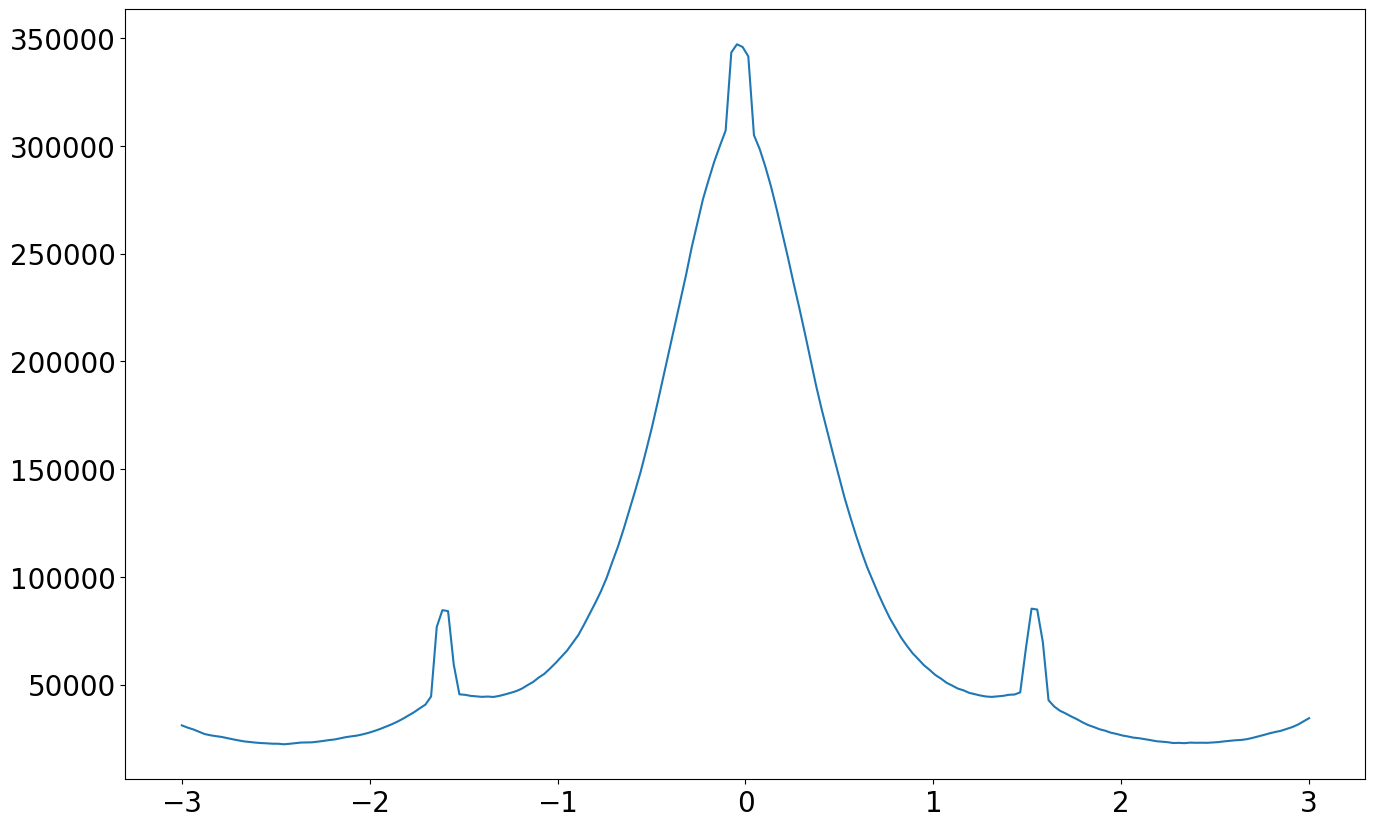

In [32]:
plt.figure(figsize=(16,10))

plt.plot(angle, distribution)

plt.show()

In [33]:
def lorentzienne(x, A, x0, Gamma):
    return A*Gamma/(2*np.pi)/(Gamma**2/4 + (x-x0)**2)

[ 5.10035335e+05 -3.46716293e-02  1.01918816e+00]


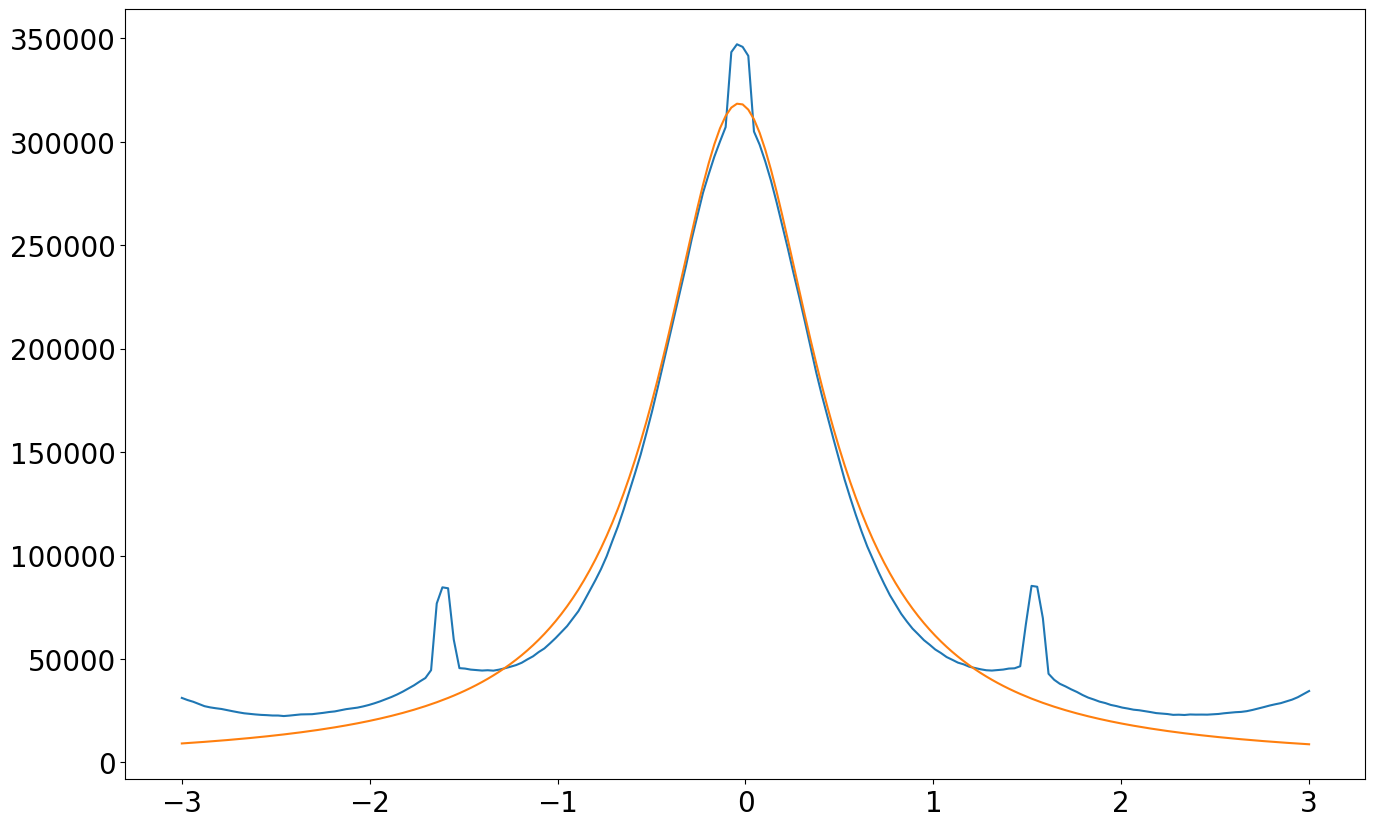

In [43]:
#On fit la distributin des angles avec une lorentzienne en conservant les parametres du fit

popt2, pcov2 = curve_fit(lorentzienne, angle, distribution, p0 = np.array([1e6, 0, 0.1]))
np.savetxt(data + "parametres_fit_lorentzien_distribution_angluaire.txt", popt2, header = '         multiplicateur                   moyenne                   largeur')
print(popt2)
plt.figure(figsize=(16,10))

plt.plot(angle, distribution)
plt.plot(angle, lorentzienne(angle, popt2[0], popt2[1], popt2[2]))
plt.savefig(data + 'comparison_fit_data_distribution_angulaire_lorentzienne')
plt.show()

### Version longue avec porte

### Version courte avec porte

In [13]:
#le principe de ces lignes de code est identiaue a celui du code por le MSD

autocorr_vx = np.zeros((N,frame_par_fichier-2))
autocorr_vy = np.zeros((N,frame_par_fichier-2)) 
autocorr_angle = np.zeros((N,frame_par_fichier-2))
Tau = np.zeros(frame_par_fichier-2)

for i in range(N):

    if ((x[0,i+1] > 600) & (x[frame_par_fichier-1,i+1] < 800)):
    
        for j in range(frame_par_fichier-2):
            
        
            autocorr_vx[i][j] = np.mean(abs(vx[j+1:,i]*vx[:-j-1,i]))
            if np.isnan(np.mean(autocorr_vx[i][j])):
                autocorr_vx[i][j] = autocorr_vx[i][j-1]
        
            autocorr_vy[i][j] = np.mean(abs(vy[j+1:,i]*vy[:-j-1,i]), where = ((abs(vy[j+1:,i]*vy[:-j-1,i])) < 1000).all())
            if np.isnan(autocorr_vx[i][j]):
                autocorr_vy[i][j] = autocorr_vy[i][j-1]

            autocorr_angle[i][j] = np.mean(abs(np.arctan2(vy[j+1:,i],vx[j+1:,i]))*abs(np.arctan2(vy[:-j-1,i],vx[:-j-1,i])), where = ((abs(vy[j+1:,i]*vy[:-j-1,i])) < 100).all())
            if np.isnan(autocorr_vx[i][j]):
                autocorr_angle[i][j] = autocorr_angle[i][j-1]
            
            Tau[j] = (j+1)*(x[1][0]-x[0][0])
        

### Sans porte

In [ ]:
#le principe de ces lignes de code est identiaue a celui du code por le MSD

autocorr_vx = np.zeros((N,frame_par_fichier-2))
autocorr_vy = np.zeros((N,frame_par_fichier-2)) 
autocorr_angle = np.zeros((N,frame_par_fichier-2))
Tau = np.zeros(frame_par_fichier-2)

for i in range(N):

    for j in range(frame_par_fichier-2):
            
        autocorr_vx[i][j] = np.mean(abs(vx[j+1:,i]*vx[:-j-1,i]))
        autocorr_vy[i][j] = np.mean(abs(vy[j+1:,i]*vy[:-j-1,i])) 
        autocorr_angle[i][j] = np.mean(abs(np.arctan2(vy[j+1:,i],vx[j+1:,i]))*abs(np.arctan2(vy[:-j-1,i],vx[:-j-1,i])))
        Tau[j] = (j+1)*(x[1][0]-x[0][0])
        

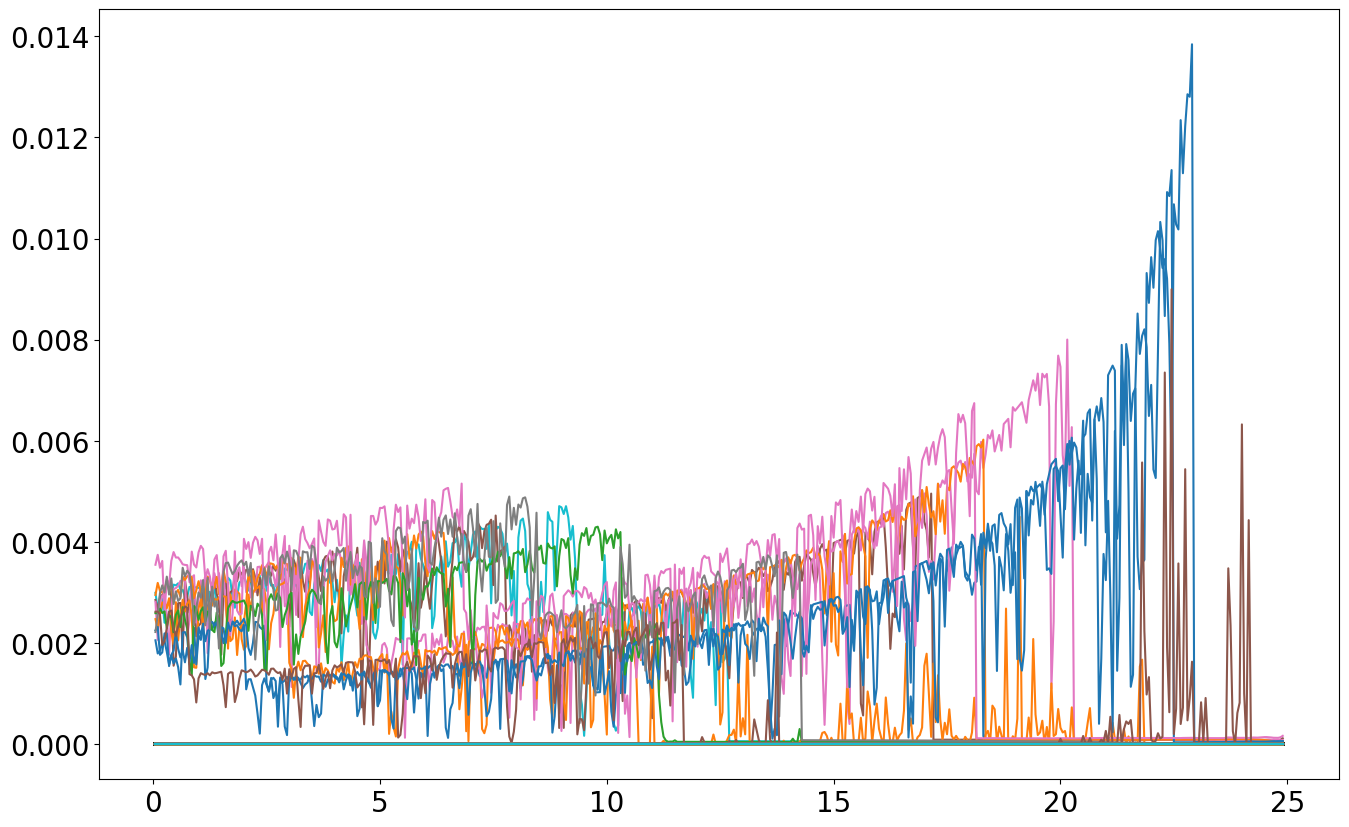

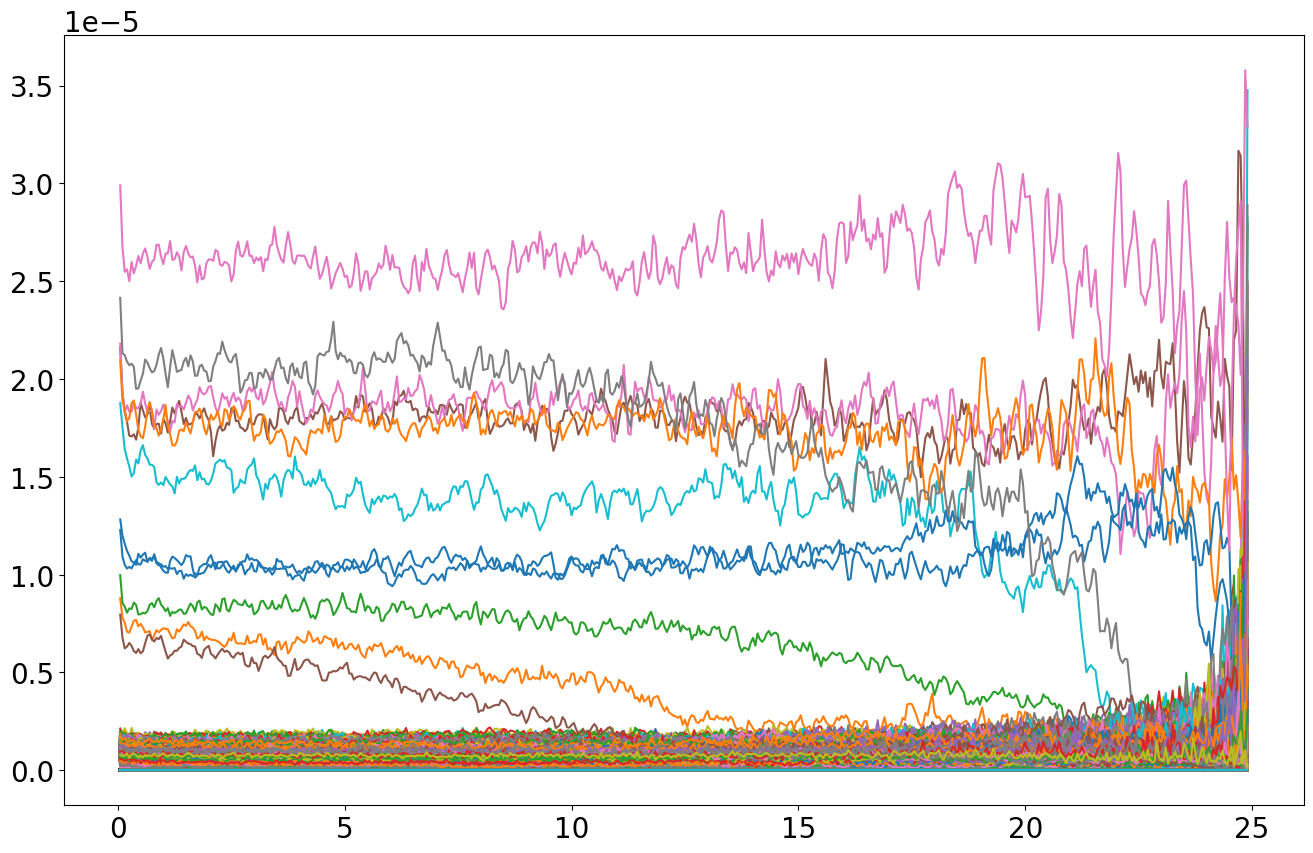

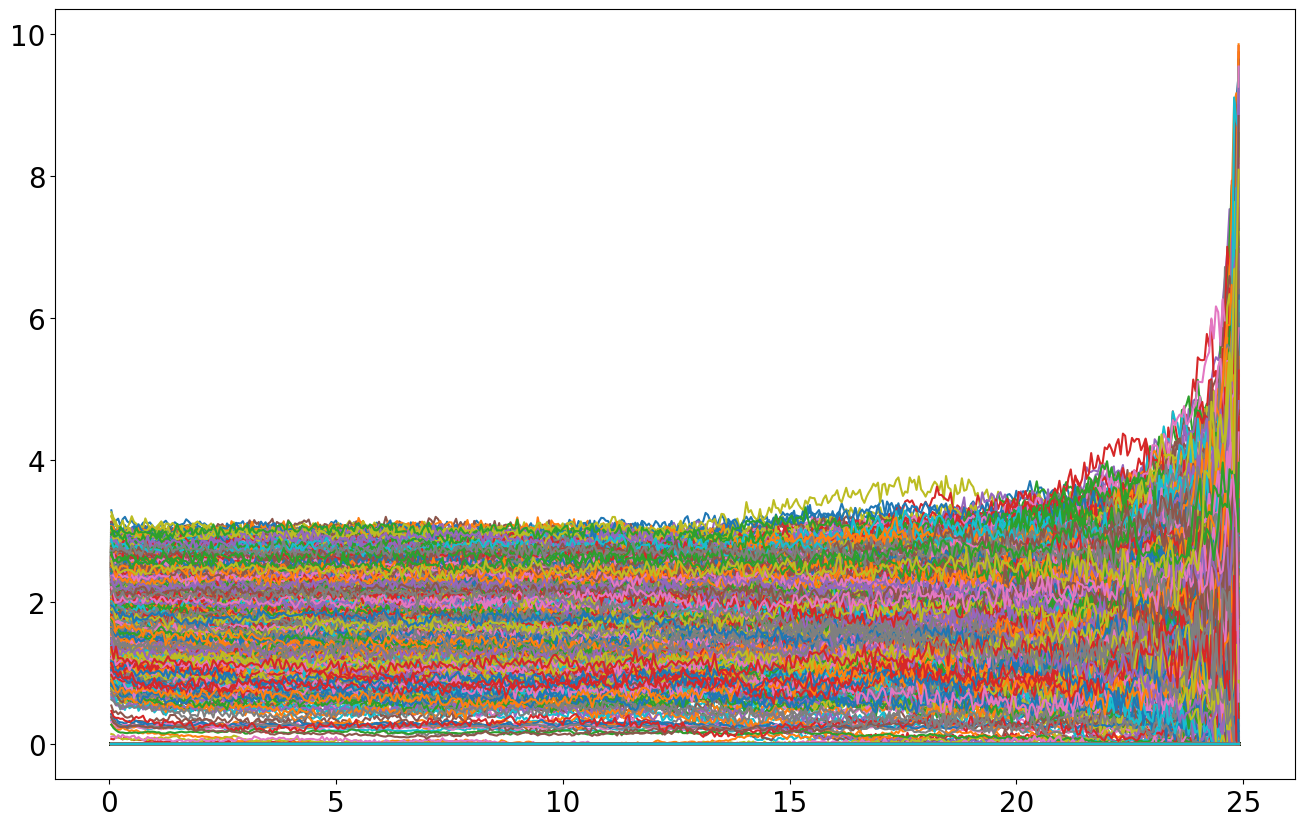

In [14]:
plt.figure(figsize=(16,10))
for i in range(N):
    plt.plot(Tau, autocorr_vx[i])
plt.show()

plt.figure(figsize=(16,10))
for i in range(N): 
    plt.plot(Tau, autocorr_vy[i])
plt.show()

plt.figure(figsize=(16,10))
for i in range(N):
    plt.plot(Tau, autocorr_angle[i])    
plt.show()

In [15]:
mean_autocorr_vx = np.mean(autocorr_vx, axis = 0, where = np.sum(autocorr_vx, axis = 0) > 0)
mean_autocorr_vy = np.mean(autocorr_vy, axis = 0, where = np.sum(autocorr_vy, axis = 0) > 0)
mean_autocorr_angle = np.mean(autocorr_angle, axis = 0)

np.savetxt(data + "autocorr_vx.txt", np.array([Tau, mean_autocorr_vx]), header = 'Tau  mean_autocorr_vx')
np.savetxt(data + "autocorr_vy.txt", np.array([Tau, mean_autocorr_vy]), header = 'Tau  mean_autocorr_vy')
np.savetxt(data + "autocorr_angle.txt", np.array([Tau, mean_autocorr_angle]), header = 'Tau  mean_autocorr_angle')

In [16]:
print(np.shape(autocorr_vy))

(8000, 498)


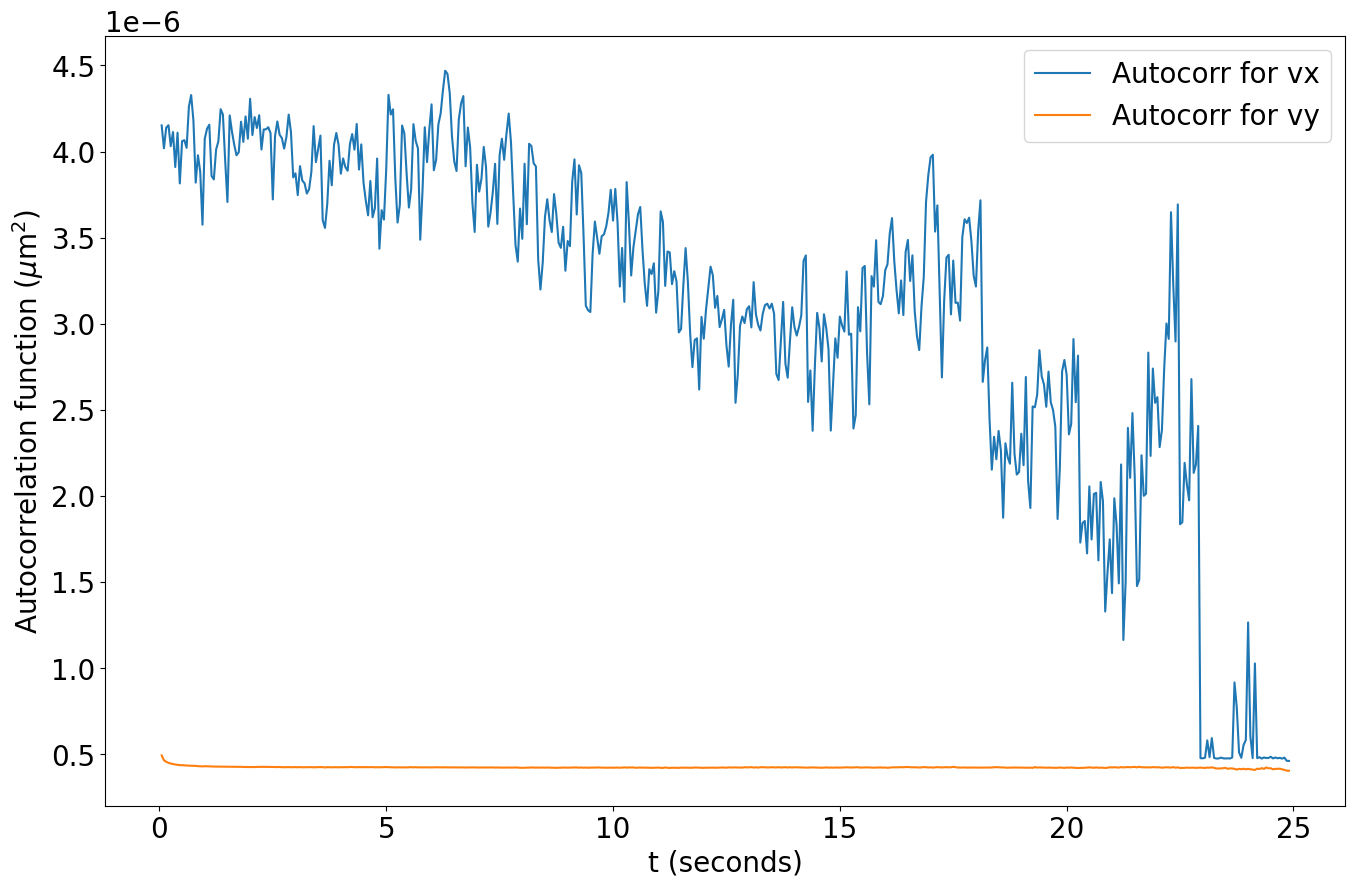

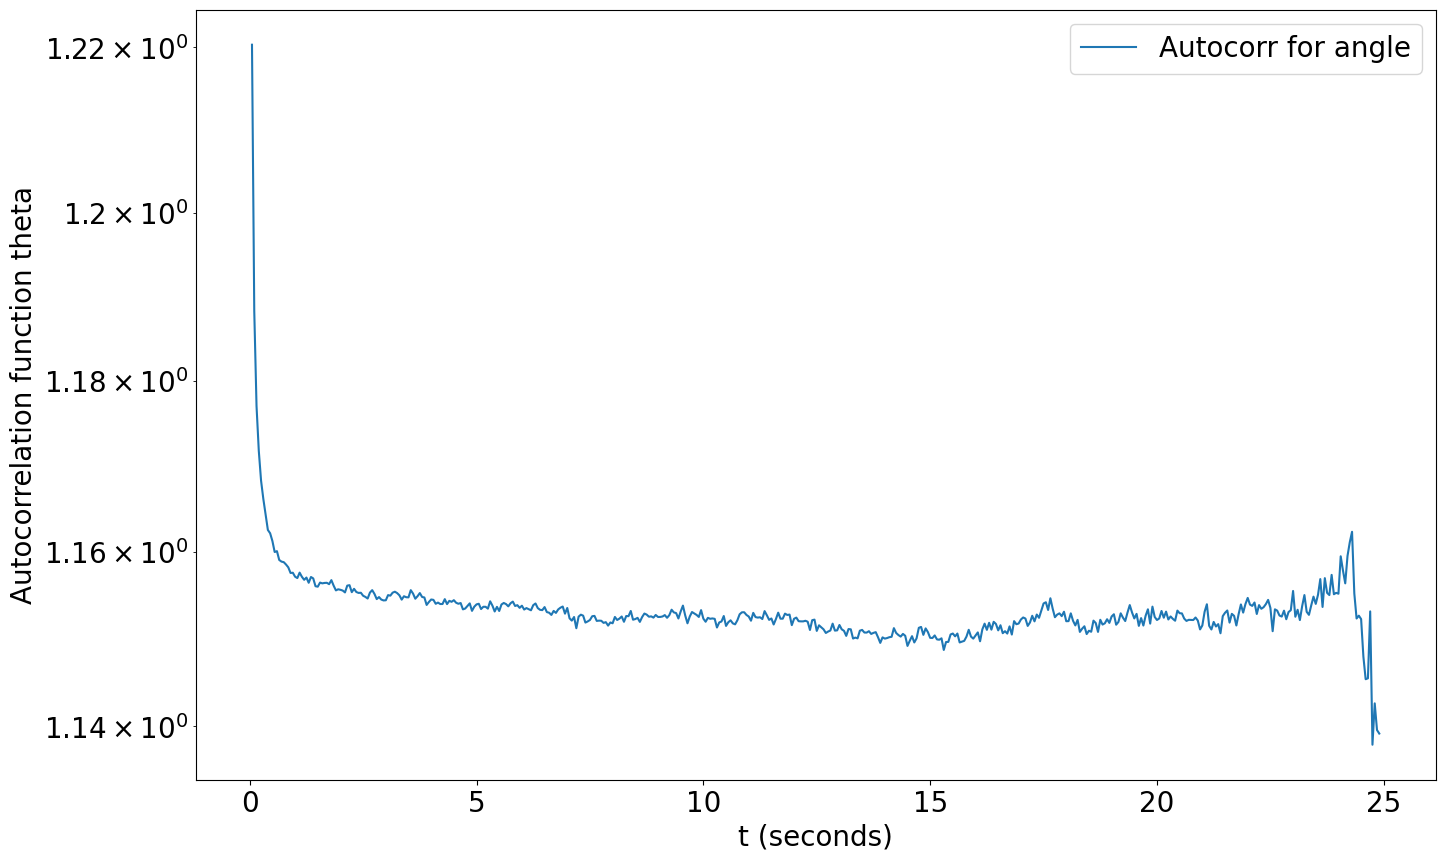

In [17]:
plt.figure(figsize=(16,10))
plt.plot(Tau, mean_autocorr_vx, label = 'Autocorr for vx')
plt.plot(Tau, mean_autocorr_vy, label = 'Autocorr for vy')
#plt.xlim(0,2)
#plt.ylim(0,200000)
plt.xlabel('t (seconds)')
plt.ylabel(r'Autocorrelation function ($\mu$m$^2$)')

plt.legend()

plt.savefig(data + 'autocorr_vx_vy')

plt.show()


plt.figure(figsize=(16,10))
plt.plot(Tau, mean_autocorr_angle, label = 'Autocorr for angle')
#plt.xlim(0,10)
#plt.ylim(0,200000)
plt.xlabel('t (seconds)')
plt.ylabel(r'Autocorrelation function theta')
plt.xscale('linear')
plt.yscale('log')

plt.legend()

plt.savefig(data + 'autocorr_angle')

plt.show()

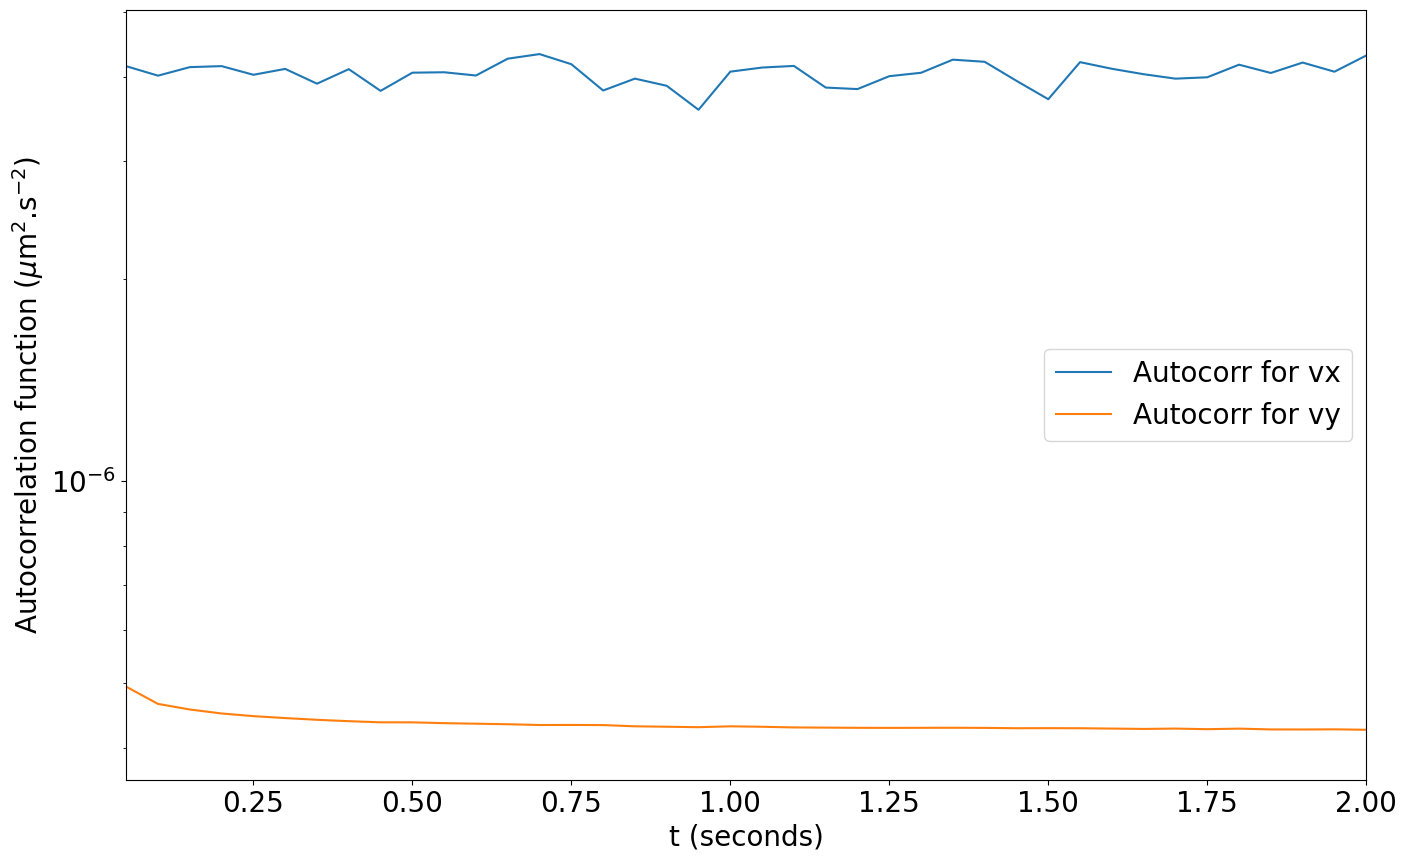

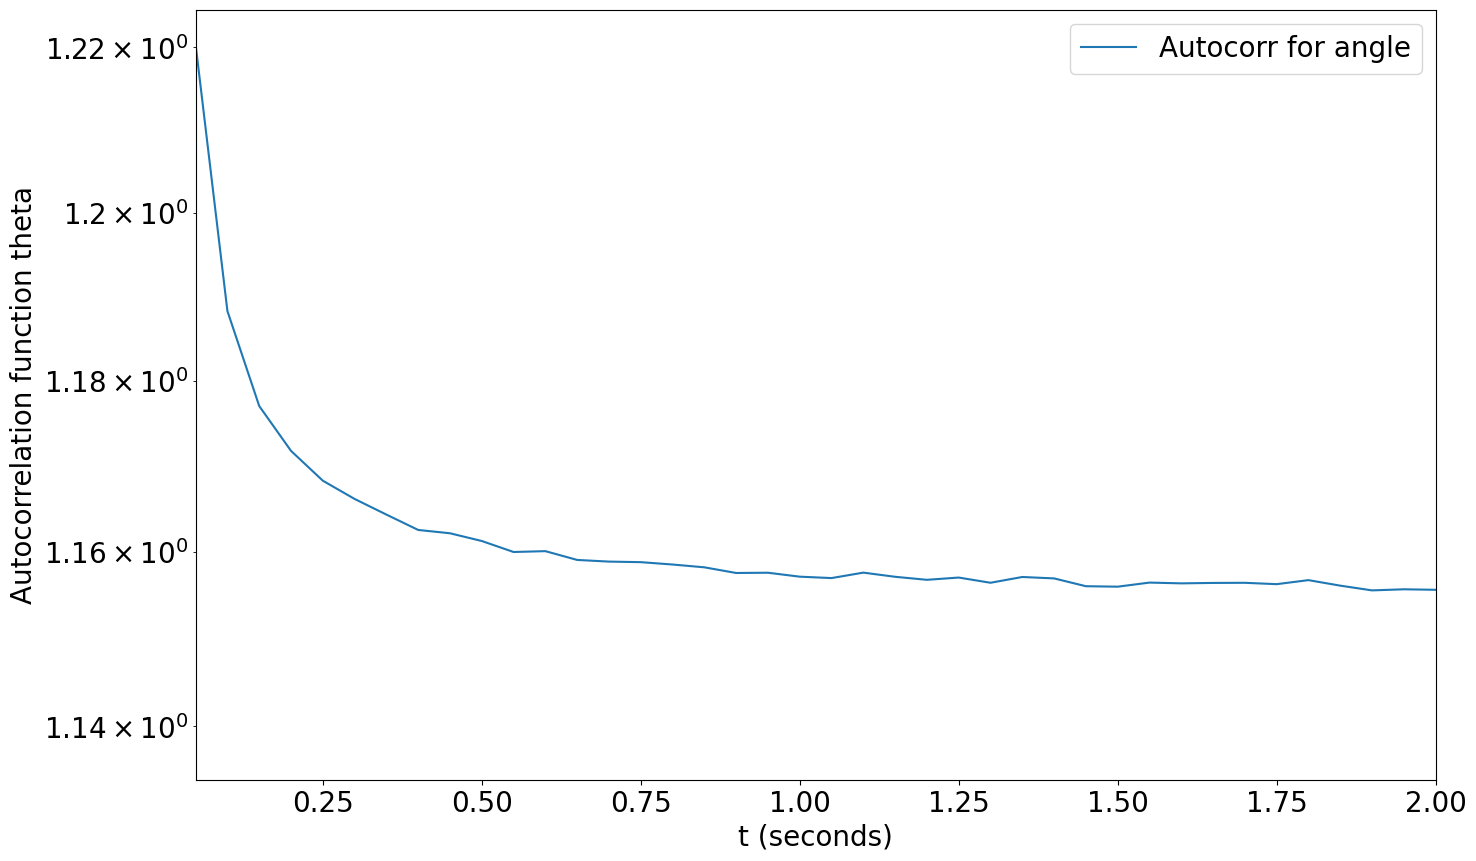

In [18]:
plt.figure(figsize=(16,10))
plt.plot(Tau, mean_autocorr_vx, label = 'Autocorr for vx')
plt.plot(Tau, mean_autocorr_vy, label = 'Autocorr for vy')
plt.xlim(0.05,2)
#plt.ylim(0,200000)
plt.xlabel('t (seconds)')
plt.ylabel(r'Autocorrelation function ($\mu$m$^2$.s$^{-2}$)')
plt.xscale('linear')
plt.yscale('log')
plt.legend()

plt.savefig(data + 'autocorr_vx_vy_reduit')

plt.show()


plt.figure(figsize=(16,10))
plt.plot(Tau, mean_autocorr_angle, label = 'Autocorr for angle')
plt.xlim(0.05,2)
#plt.ylim(0.35,0.5)
plt.xlabel('t (seconds)')
plt.ylabel(r'Autocorrelation function theta')
plt.xscale('linear')
plt.yscale('log')

plt.legend()

plt.savefig(data + 'autocorr_angle_reduit')

plt.show()

In [19]:
def f_exp(t, A, t0, tau, B):
    return A*np.exp(-(t-t0)/tau) + B

In [20]:
poptx, pcovx = curve_fit(f_exp, Tau[Tau<0.30], mean_autocorr_vx[Tau<0.30], p0 = np.array([0.00001, 0.2, 0.01, 0.000001]))
popty, pcovy = curve_fit(f_exp, Tau[Tau<0.30], mean_autocorr_vy[Tau<0.30], p0 = np.array([0.0001, 00.1, 0.1, 0.0004]))

print(poptx)
print(popty)

np.savetxt(data + "fit_exp_autocorr.txt", np.array([poptx, popty]), header = 'A    t0     tau     B')

plt.figure(figsize=(16,10))
plt.plot(Tau, mean_autocorr_vx, label = 'Autocorr for vx')
plt.plot(Tau, mean_autocorr_vy, label = 'Autocorr for vx')

plt.plot(Tau, f_exp(Tau, poptx[0], poptx[1], poptx[2], poptx[3]), label = 'fit Autocorr for vx')
plt.plot(Tau, f_exp(Tau, popty[0], popty[1], popty[2], popty[3]), label = 'fit Autocorr for vy')

#plt.xlim(0.05,2)
#plt.ylim(800,6000)
plt.xlabel('t (seconds)')
plt.ylabel(r'Autocorrelation function ($\mu$m$^2$.s$^{-2}$)')
plt.xscale('linear')
plt.yscale('log')

plt.savefig(data + 'autocorr_vx_vy_reduit')

plt.legend()
plt.show()

C:\Windows\Temp\ipykernel_7128\639058298.py:2: RuntimeWarning: overflow encountered in exp
  return A*np.exp(-(t-t0)/tau) + B


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.